In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import seaborn as sns
import numpy as np
from env import user,password,host
import os
import acquire
import prepare
import explore
import env
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings("ignore")

## Acquisition

In [2]:
# Make functions
def check_file_exists(fn, query, url):
    '''
    this function checks to see if the .csv file already exists. If yes it reads it
    '''
    if os.path.isfile(fn):
        print('csv file found and loaded\n')
        return pd.read_csv(fn, index_col=0)
    else: 
        print('creating df and exporting csv\n')
        df = pd.read_sql(query, url)
        df.to_csv(fn)
        return df 
    
def get_zillow_data():
    '''
    This function brings in the Zillow DF using mySQL from the Codeup server
    It uses the env.py file for access
    '''
    url = env.get_db_url('zillow')
    filename = 'zillow.csv'
    query = '''
        select taxvaluedollarcnt, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, fips,transactiondate
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid IN (261 , 279)
            ;
    '''        
    df = check_file_exists(filename, query, url)
    return df 

In [3]:
#get data
get_zillow_data()

csv file found and loaded



,taxvaluedollarcnt,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,transactiondate
0,1023282.0,4.0,3.5,3100.0,6059.0,4506.0,2017-01-01
1,464000.0,2.0,1.0,1465.0,6111.0,12647.0,2017-01-01
2,564778.0,3.0,2.0,1243.0,6059.0,8432.0,2017-01-01
3,145143.0,4.0,3.0,2376.0,6037.0,13038.0,2017-01-01
4,773303.0,4.0,3.0,2962.0,6037.0,63000.0,2017-01-01
...,...,...,...,...,...,...,...
52437,354621.0,2.0,2.0,1286.0,6037.0,47405.0,2017-09-20
52438,67205.0,4.0,2.0,1612.0,6111.0,12105.0,2017-09-21
52439,49546.0,3.0,1.0,1032.0,6037.0,5074.0,2017-09-21
52440,522000.0,3.0,2.0,1762.0,6037.0,6347.0,2017-09-25


In [4]:
# make sure the csv is working
get_zillow_data()


csv file found and loaded



,taxvaluedollarcnt,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,transactiondate
0,1023282.0,4.0,3.5,3100.0,6059.0,4506.0,2017-01-01
1,464000.0,2.0,1.0,1465.0,6111.0,12647.0,2017-01-01
2,564778.0,3.0,2.0,1243.0,6059.0,8432.0,2017-01-01
3,145143.0,4.0,3.0,2376.0,6037.0,13038.0,2017-01-01
4,773303.0,4.0,3.0,2962.0,6037.0,63000.0,2017-01-01
...,...,...,...,...,...,...,...
52437,354621.0,2.0,2.0,1286.0,6037.0,47405.0,2017-09-20
52438,67205.0,4.0,2.0,1612.0,6111.0,12105.0,2017-09-21
52439,49546.0,3.0,1.0,1032.0,6037.0,5074.0,2017-09-21
52440,522000.0,3.0,2.0,1762.0,6037.0,6347.0,2017-09-25


In [5]:
# check import funcions
df = acquire.get_zillow_data()

csv file found and loaded



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxvaluedollarcnt             52441 non-null  float64
 1   bedroomcnt                    52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   calculatedfinishedsquarefeet  52360 non-null  float64
 4   fips                          52442 non-null  float64
 5   lotsizesquarefeet             52073 non-null  float64
 6   transactiondate               52442 non-null  object 
dtypes: float64(6), object(1)
memory usage: 3.2+ MB


## Prep

In [7]:
# drop the non 2017
df = df[df['transactiondate'].str.startswith('2017')]



In [8]:
df.transactiondate.max()

'2017-09-25'

In [9]:
def prep_zillow(df):
    '''
    this function cleans up the data. It renames the colums. It makes floats int's, and drops null's.
    Defines the fips as counties
    
    '''
    #rename columns
    df = df.rename(columns = {'bedroomcnt':'bedrooms',
                     'bathroomcnt':'bathrooms',
                     'calculatedfinishedsquarefeet':'area',
                     'taxvaluedollarcnt':'taxvalue',
                     'fips':'county'})
    #dropping nulls
    df = df.dropna()
    # make floats into Int's
    make_ints = ['bedrooms','bathrooms','area','taxvalue']
    for col in make_ints:
        df[col] = df[col].astype(int)
    # define fips as county names    
    df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})
    df = df[df['transactiondate'].str.startswith('2017')]
    df = df.drop('transactiondate', axis=1)
    return df

In [10]:
df = prepare.prep_zillow(df)

In [11]:
# check to ensure we didn't drop to many..... 84 is not bad
52442-52358

84

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50455 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   county          50455 non-null  object
 1   taxvalue        50455 non-null  int64 
 2   bedrooms        50455 non-null  int64 
 3   bathrooms       50455 non-null  int64 
 4   area            50455 non-null  int64 
 5   lot             50455 non-null  int64 
 6   county_LA       50455 non-null  uint8 
 7   county_Orange   50455 non-null  uint8 
 8   county_Ventura  50455 non-null  uint8 
dtypes: int64(5), object(1), uint8(3)
memory usage: 2.8+ MB


## Exploration

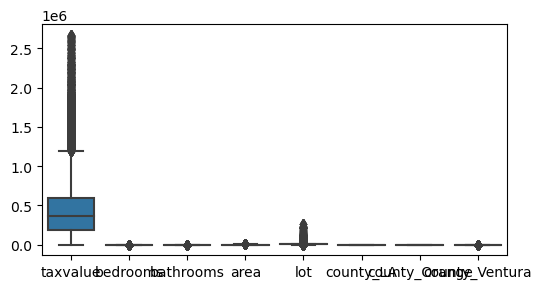

In [13]:
#outliers?
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=df)
plt.show()

In [14]:
# dropping target to see others better 
dfa = df.drop(columns='taxvalue')

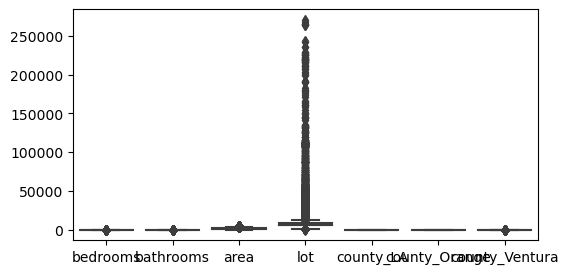

In [15]:
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=dfa)
plt.show()

In [16]:
dfb = df.drop(columns=['area','taxvalue'])

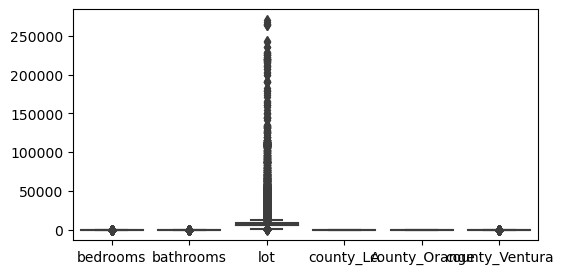

In [17]:
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=dfb)
plt.show()

In [18]:
# there are some outliers in the value, area, bathroom, and bedroom columns

### Im going to find a Z-score for these and drop all with a score greater than 3

In [19]:
# Using Zscore detrmine outliers to remove limit Z score to 3
# Define the z-score threshold for outlier detection
z_threshold = 3
# Calculate the z-scores for each numerical column in the DataFrame
numerical_columns = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
z_scores = np.abs(stats.zscore(df[numerical_columns]))
# Create a boolean mask for outlier detection
outlier_mask = (z_scores > z_threshold).any(axis=1)
# Filter out the rows containing outliers
df_no_outliers = df[~outlier_mask]

In [20]:
#Make sure we dont drop to many rows
#shape before and after outlier removal was 52358
# 1200ish not to bad.... should give a better picture of average to use in a predictive model
# adding this to the prep function
print(df_no_outliers.shape)

(48260, 9)


In [21]:
def prep_zillow(df):
    '''
    This function cleans up the data, renames columns, converts floats to ints, drops nulls, defines fips as counties, and removes outliers.
    '''
    # Rename columns
    df = df.rename(columns={'bedroomcnt': 'bedrooms',
                            'bathroomcnt': 'bathrooms',
                            'calculatedfinishedsquarefeet': 'area',
                            'taxvaluedollarcnt': 'taxvalue',
                            'fips': 'county'})

    # Dropping nulls
    df = df.dropna()

    # Make floats into ints
    make_ints = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
    for col in make_ints:
        df[col] = df[col].astype(int)

    # Define fips as county names
    df['county'] = df['county'].map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

    # Remove outliers
    z_threshold = 3
    numerical_columns = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
    z_scores = np.abs(stats.zscore(df[numerical_columns]))
    outlier_mask = (z_scores < z_threshold).all(axis=1)
    df = df[outlier_mask]

    # Drop the 'transactiondate' column
    df = df.drop('transactiondate', axis=1)

    return df



In [22]:
# functon, function check with dummies
#  import 
df = acquire.get_zillow_data()

csv file found and loaded



In [23]:
df = prepare.prep_zillow(df)


In [24]:
df.head()

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
0,Orange,1023282,4,3,3100,4506,0,1,0
1,Ventura,464000,2,1,1465,12647,0,0,1
2,Orange,564778,3,2,1243,8432,0,1,0
3,LA,145143,4,3,2376,13038,1,0,0
4,LA,773303,4,3,2962,63000,1,0,0


In [25]:
df.describe(include='all')

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
count,50456,5.045600e+04,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,LA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,32556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.539024e+05,3.267560,2.157583,1828.633958,8938.304780,0.645235,0.269938,0.084826
std,NaN,3.857351e+05,0.880761,0.847716,777.710962,11693.555942,0.478447,0.443932,0.278626
min,NaN,1.000000e+03,1.000000,0.000000,152.000000,236.000000,0.000000,0.000000,0.000000
25%,NaN,1.888405e+05,3.000000,2.000000,1259.000000,5533.000000,0.000000,0.000000,0.000000
50%,NaN,3.640790e+05,3.000000,2.000000,1634.500000,6761.000000,1.000000,0.000000,0.000000
75%,NaN,5.900000e+05,4.000000,3.000000,2233.000000,8525.250000,1.000000,1.000000,0.000000


In [26]:
# need some dummies for the counties!!
df_dummy=pd.get_dummies(columns=['county'], data=df)
df_dummy.head()
# add to prep file

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura,county_LA,county_Orange,county_Ventura
0,1023282,4,3,3100,4506,0,1,0,0,1,0
1,464000,2,1,1465,12647,0,0,1,0,0,1
2,564778,3,2,1243,8432,0,1,0,0,1,0
3,145143,4,3,2376,13038,1,0,0,1,0,0
4,773303,4,3,2962,63000,1,0,0,1,0,0


In [27]:
# Br and Bath just became catagoricle
# need another numerical column or this is no longer a regression project
# going to add lotsizesquarefeet and start from the top

In [28]:
def get_zillow_data2():
    '''
    This function brings in the Zillow DF using mySQL from the Codeup server
    It uses the env.py file for access
    '''
    url = env.get_db_url('zillow')
    filename = 'zillow.csv'
    query = '''
        select taxvaluedollarcnt, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, fips, lotsizesquarefeet, transactiondate
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid IN (261 , 279)
            ;
    '''        
    df = check_file_exists(filename, query, url)
    return df 

In [29]:
df2=get_zillow_data2()

csv file found and loaded



In [30]:
df2.lotsizesquarefeet.describe()


count    5.207300e+04
mean     1.133952e+04
std      8.674680e+04
min      2.360000e+02
25%      5.583000e+03
50%      6.840000e+03
75%      8.798000e+03
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

### Ready to split-- prep

In [31]:
# added to prep and rerunning
# check import funcions
df = acquire.get_zillow_data()

csv file found and loaded



In [32]:
df = prepare.prep_zillow(df)


In [33]:
df.describe(include='all')

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
count,50456,5.045600e+04,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,LA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,32556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4.539024e+05,3.267560,2.157583,1828.633958,8938.304780,0.645235,0.269938,0.084826
std,NaN,3.857351e+05,0.880761,0.847716,777.710962,11693.555942,0.478447,0.443932,0.278626
min,NaN,1.000000e+03,1.000000,0.000000,152.000000,236.000000,0.000000,0.000000,0.000000
25%,NaN,1.888405e+05,3.000000,2.000000,1259.000000,5533.000000,0.000000,0.000000,0.000000
50%,NaN,3.640790e+05,3.000000,2.000000,1634.500000,6761.000000,1.000000,0.000000,0.000000
75%,NaN,5.900000e+05,4.000000,3.000000,2233.000000,8525.250000,1.000000,1.000000,0.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50456 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   county          50456 non-null  object
 1   taxvalue        50456 non-null  int64 
 2   bedrooms        50456 non-null  int64 
 3   bathrooms       50456 non-null  int64 
 4   area            50456 non-null  int64 
 5   lot             50456 non-null  int64 
 6   county_LA       50456 non-null  uint8 
 7   county_Orange   50456 non-null  uint8 
 8   county_Ventura  50456 non-null  uint8 
dtypes: int64(5), object(1), uint8(3)
memory usage: 2.8+ MB


In [35]:
train,validate,test = prepare.split_data(df)

train -> (30273, 9), 60.0%
validate -> (10091, 9),20.0%
test -> (10092, 9), 20.0%


In [36]:
train.sample(3)

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
15365,LA,39504,2,1,1158,3341,1,0,0
315,LA,70365,4,2,1464,7869,1,0,0
26756,LA,294537,3,2,1169,10498,1,0,0


### Viz

In [38]:
'''
# look at what we have
plt.figure(figsize=(16, 6))

for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, 4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    plt.hist(df[col])

plt.show()

SyntaxError: EOF while scanning triple-quoted string literal (993316800.py, line 19)

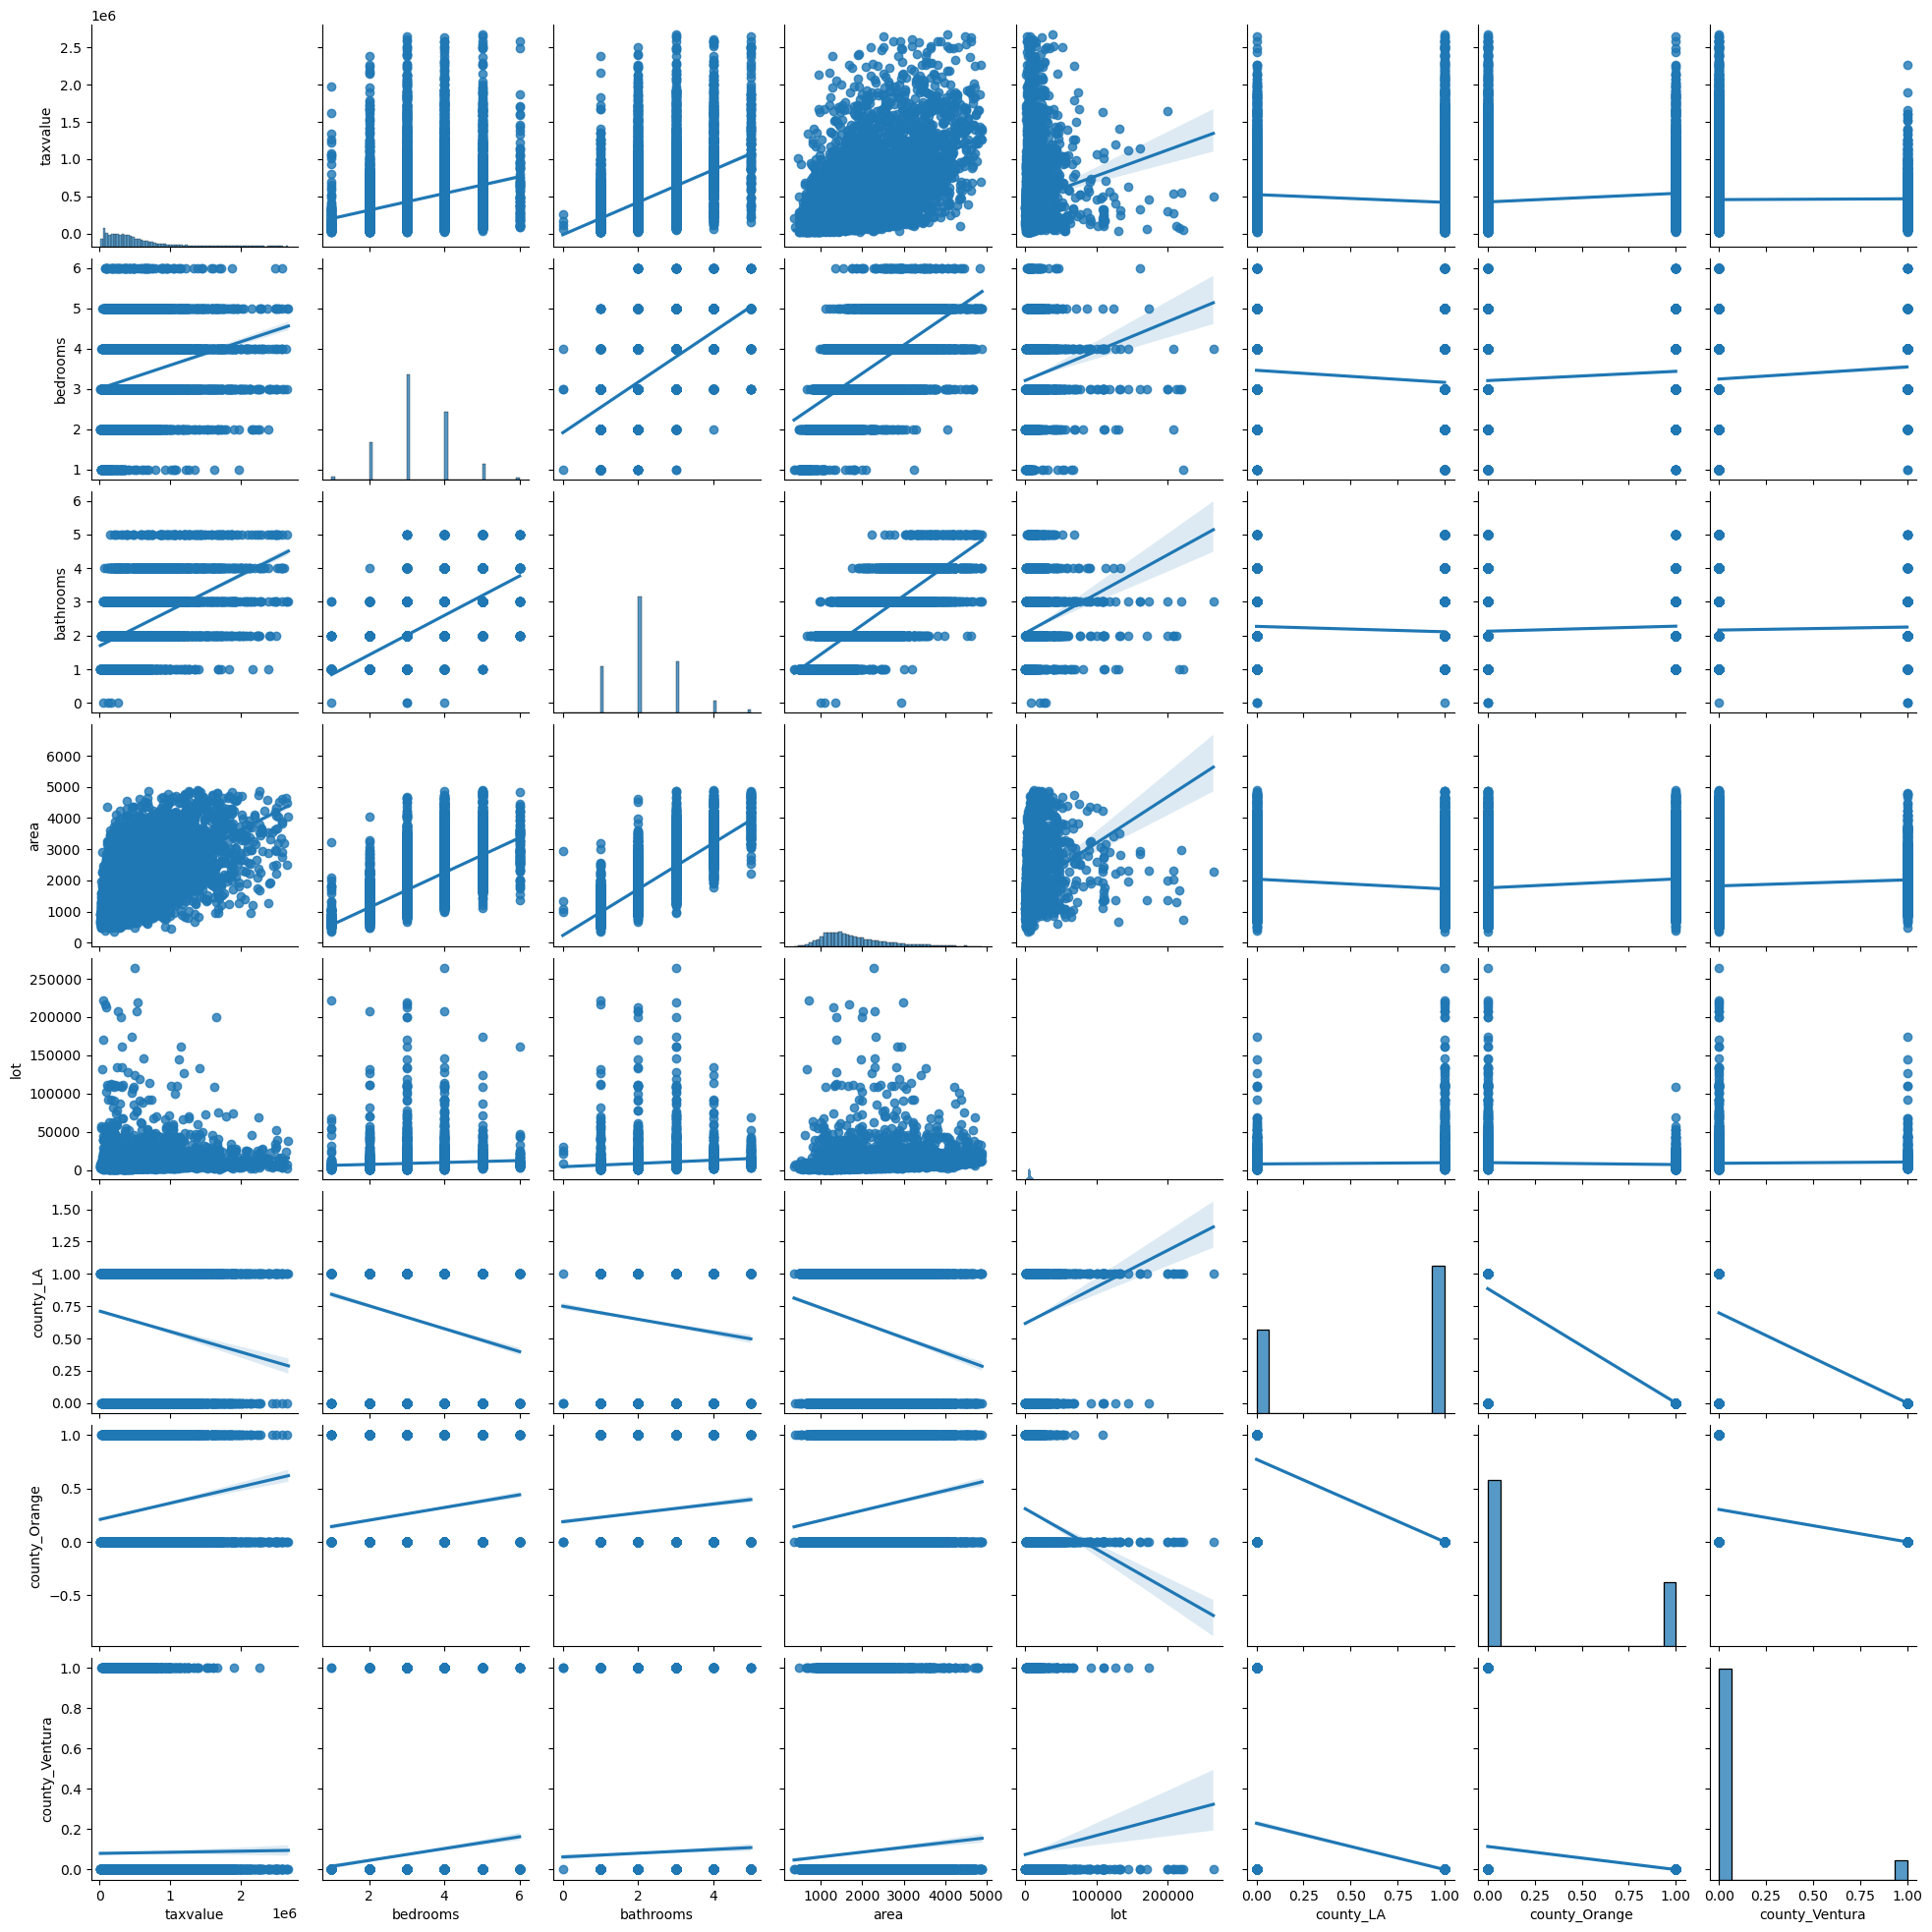

In [39]:
sns.pairplot(test, kind='reg')

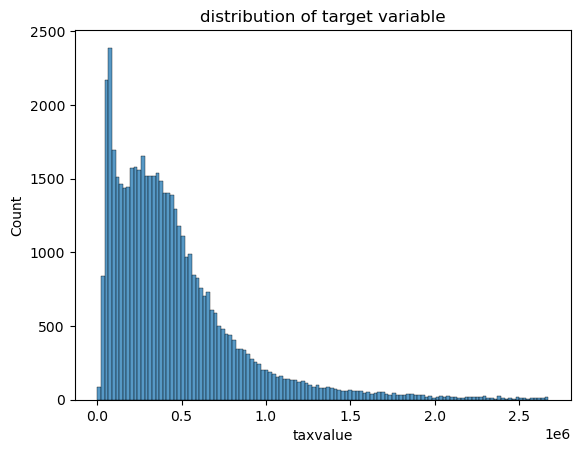

In [40]:
sns.histplot(df.taxvalue)
plt.title('distribution of target variable')
plt.show()

In [41]:
def plot_categorical_and_continuous_vars(df, cat_var, cont_var):
    # plot 1: boxplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.boxplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()
    
    # plot 2: violinplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.violinplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()
    
    # plot 3: swarmplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.swarmplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()


In [42]:
sample = train.sample(n=5000,random_state=123)

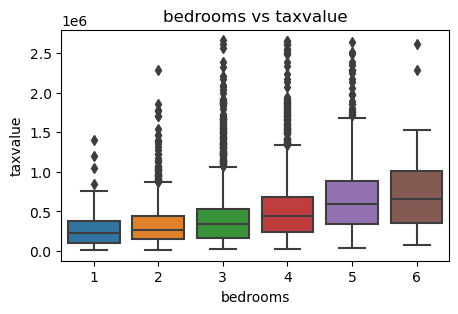

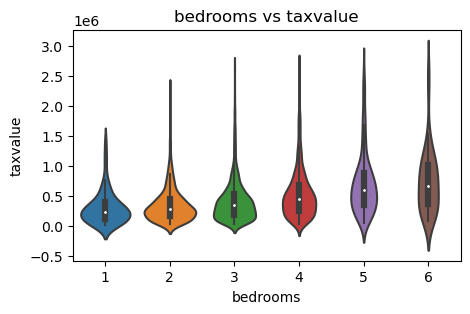

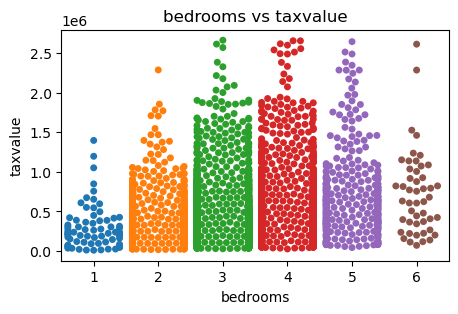

In [43]:
plot_categorical_and_continuous_vars(sample, 'bedrooms', 'taxvalue')

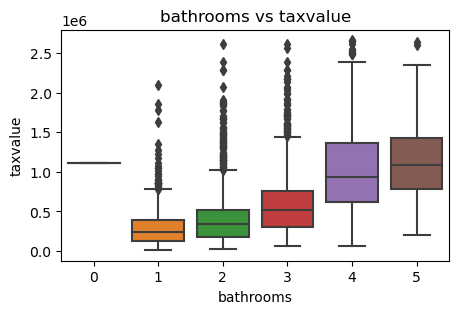

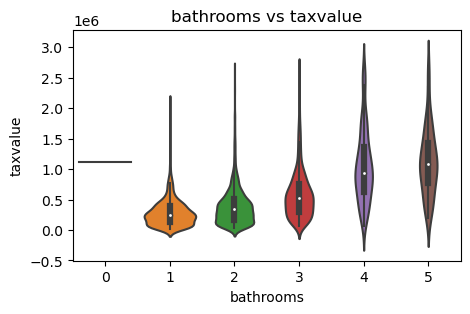

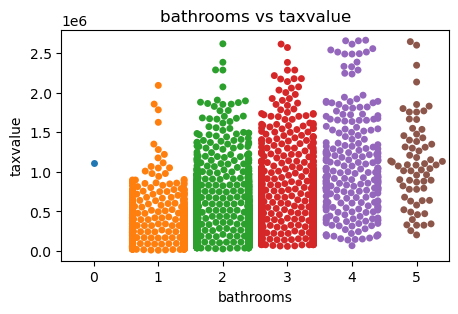

In [44]:
plot_categorical_and_continuous_vars(sample, 'bathrooms', 'taxvalue')

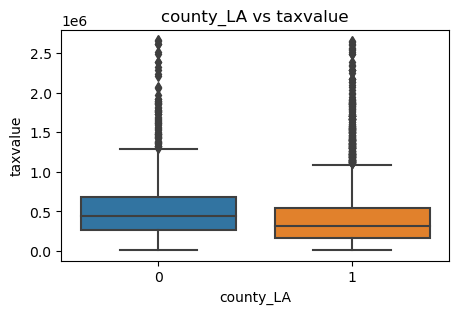

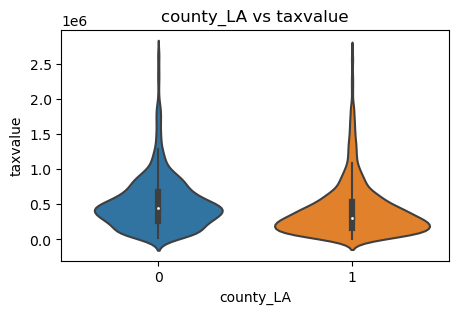

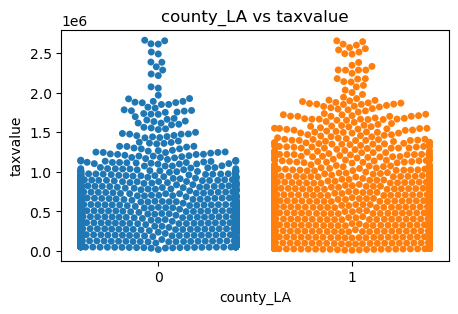

In [45]:
plot_categorical_and_continuous_vars(sample, 'county_LA', 'taxvalue')

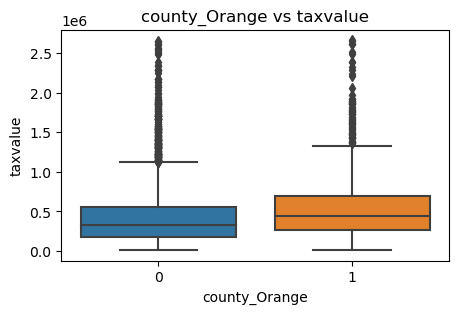

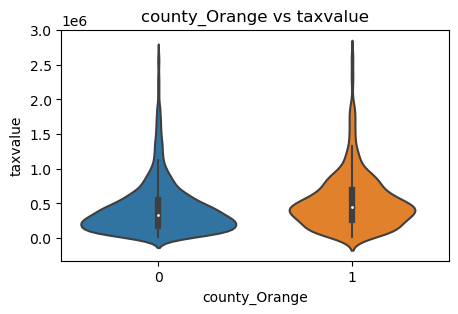

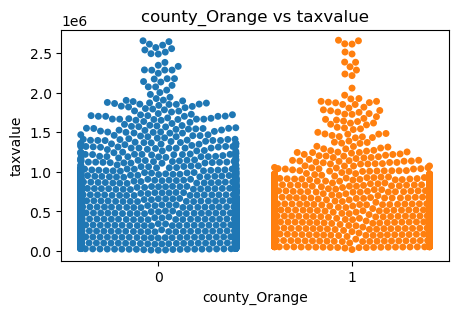

In [46]:
plot_categorical_and_continuous_vars(sample, 'county_Orange', 'taxvalue')

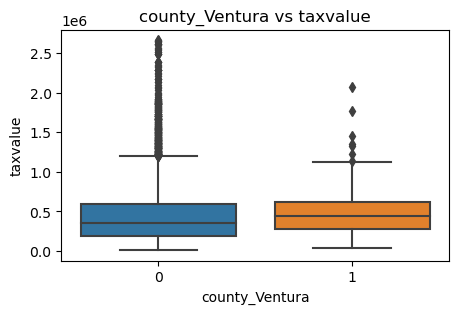

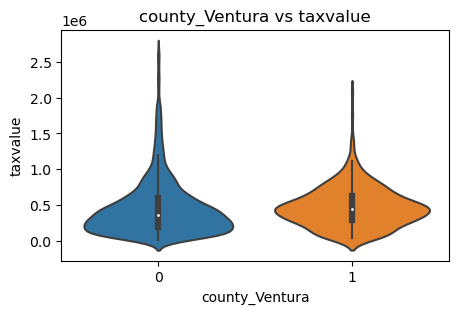

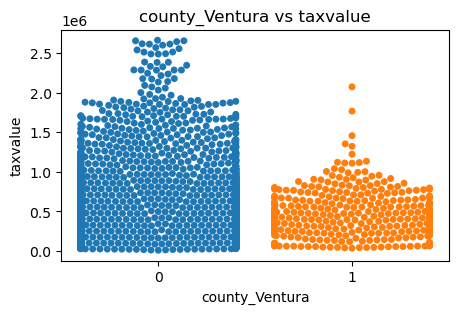

In [47]:
plot_categorical_and_continuous_vars(sample, 'county_Ventura', 'taxvalue')

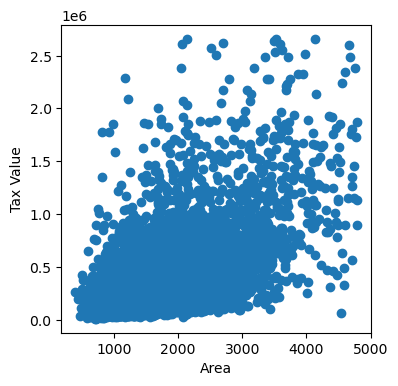

In [48]:
plt.figure(figsize=(4, 4))

plt.scatter(sample.area, sample.taxvalue)
 
plt.xlabel('Area')
plt.ylabel('Tax Value')
plt.show()


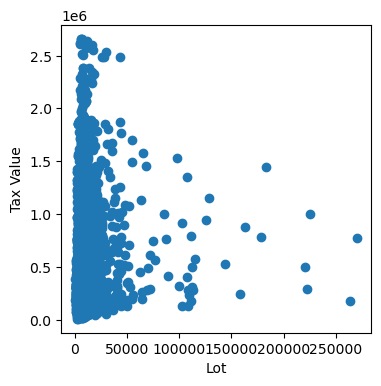

In [49]:
plt.figure(figsize=(4, 4))

plt.scatter(sample.lot, sample.taxvalue)
 
plt.xlabel('Lot')
plt.ylabel('Tax Value')
plt.show()

### Scaling --prep

In [50]:
to_scale = ['area','lot']

In [51]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    #create subplot structure
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(6,6))

    #copy the df for scaling
    df_scaled = df.copy()
    
    #fit and transform the df
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    #plot the pre-scaled data next to the post-scaled data in one row of a subplot
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()

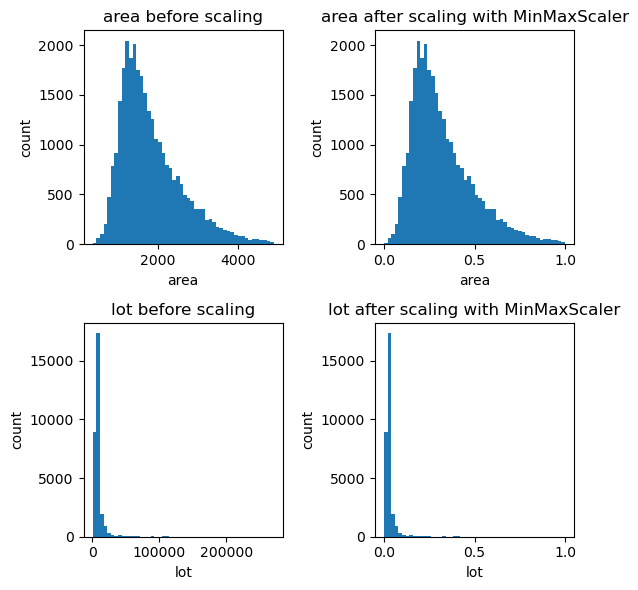

In [52]:
# call function with minmax
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

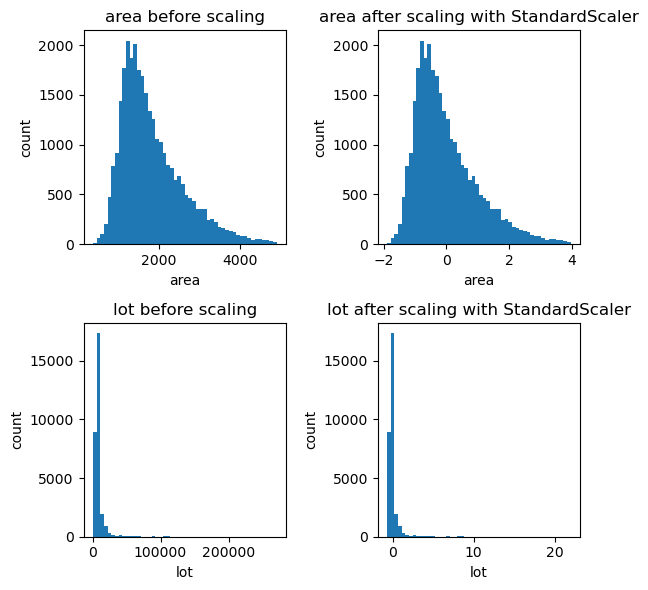

In [53]:
# call function with standard scaler
visualize_scaler(scaler=StandardScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

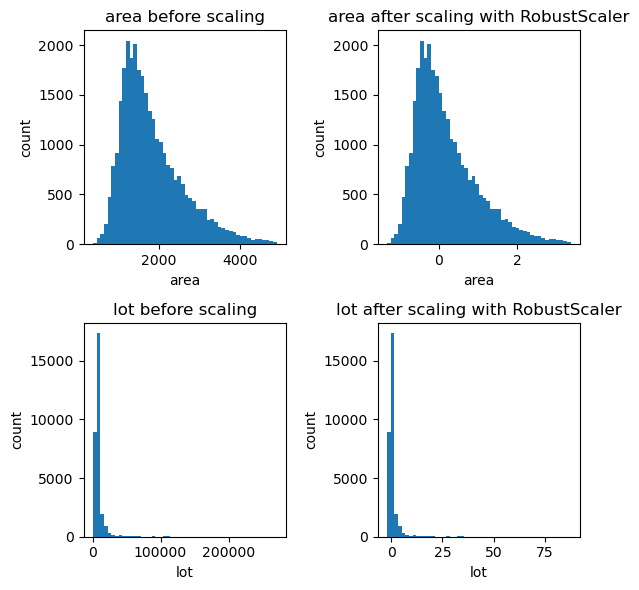

In [54]:
# call function with robustscaler
visualize_scaler(scaler=RobustScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

In [55]:
#look at original data
train[to_scale].head()

,area,lot
26821,2510,8120
21357,1353,5940
15544,1687,6002
22074,1455,6600
23745,1082,5115


In [56]:
#make it
scaler = MinMaxScaler()

#fit and use it
train_scaled = scaler.fit_transform(train[to_scale])

#convert to df
train_scaled = pd.DataFrame(train_scaled, columns=to_scale)

In [57]:
train_scaled = train_scaled.rename(columns={"area": "area_scaled", "lot": "lot_scaled"})

In [58]:
train_concatenated = pd.concat([train, train_scaled], axis=1)

In [59]:
train_concatenated.head()

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura,area_scaled,lot_scaled
26821,Ventura,403700.0,5.0,2.0,2510.0,8120.0,0.0,0.0,1.0,0.238441,0.022604
21357,Orange,862962.0,3.0,2.0,1353.0,5940.0,0.0,1.0,0.0,0.213562,0.015987
15544,LA,734067.0,3.0,2.0,1687.0,6002.0,1.0,0.0,0.0,0.328049,0.019791
22074,Orange,278712.0,4.0,2.0,1455.0,6600.0,0.0,1.0,0.0,0.201673,0.025549
23745,LA,289180.0,3.0,1.0,1082.0,5115.0,1.0,0.0,0.0,0.651035,0.034468


<AxesSubplot:>

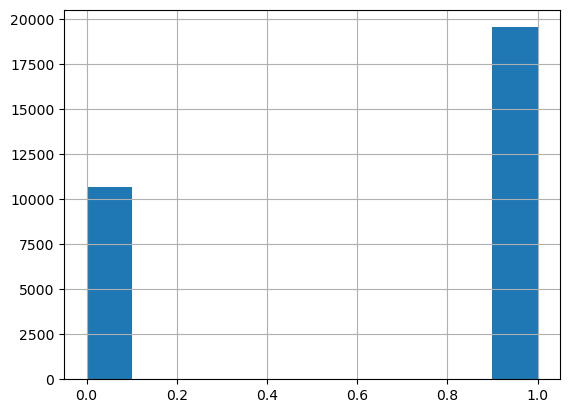

In [60]:
train.county_LA.hist()

<AxesSubplot:>

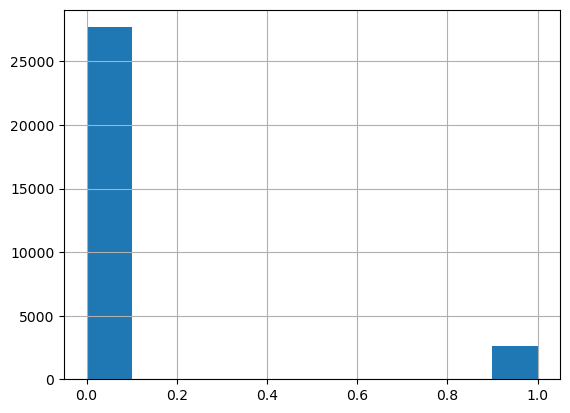

In [61]:
train.county_Ventura.hist()

<AxesSubplot:>

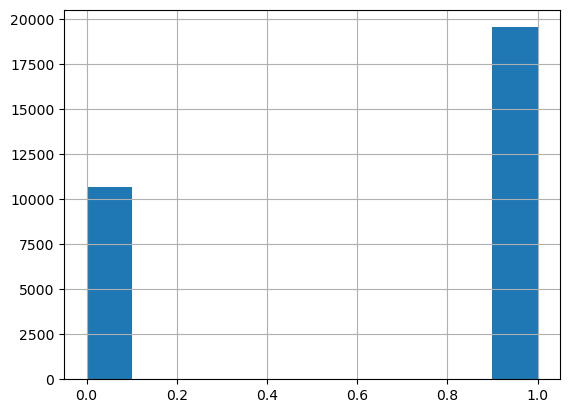

In [62]:
train.county_LA.hist()

<AxesSubplot:>

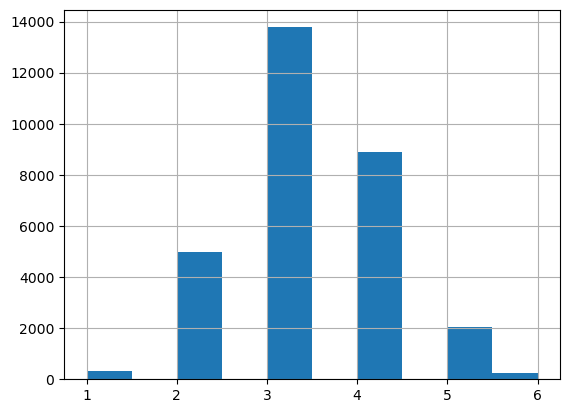

In [63]:
train.bedrooms.hist()

<AxesSubplot:>

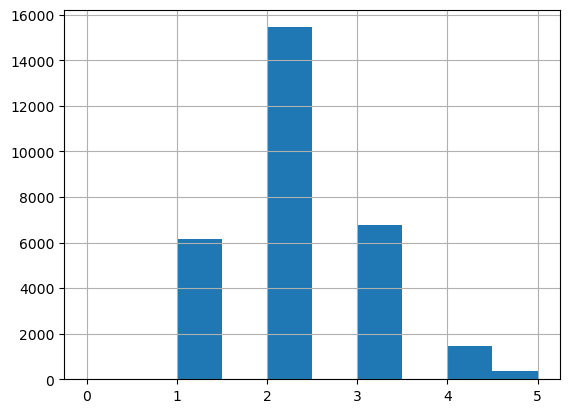

In [64]:
train.bathrooms.hist()

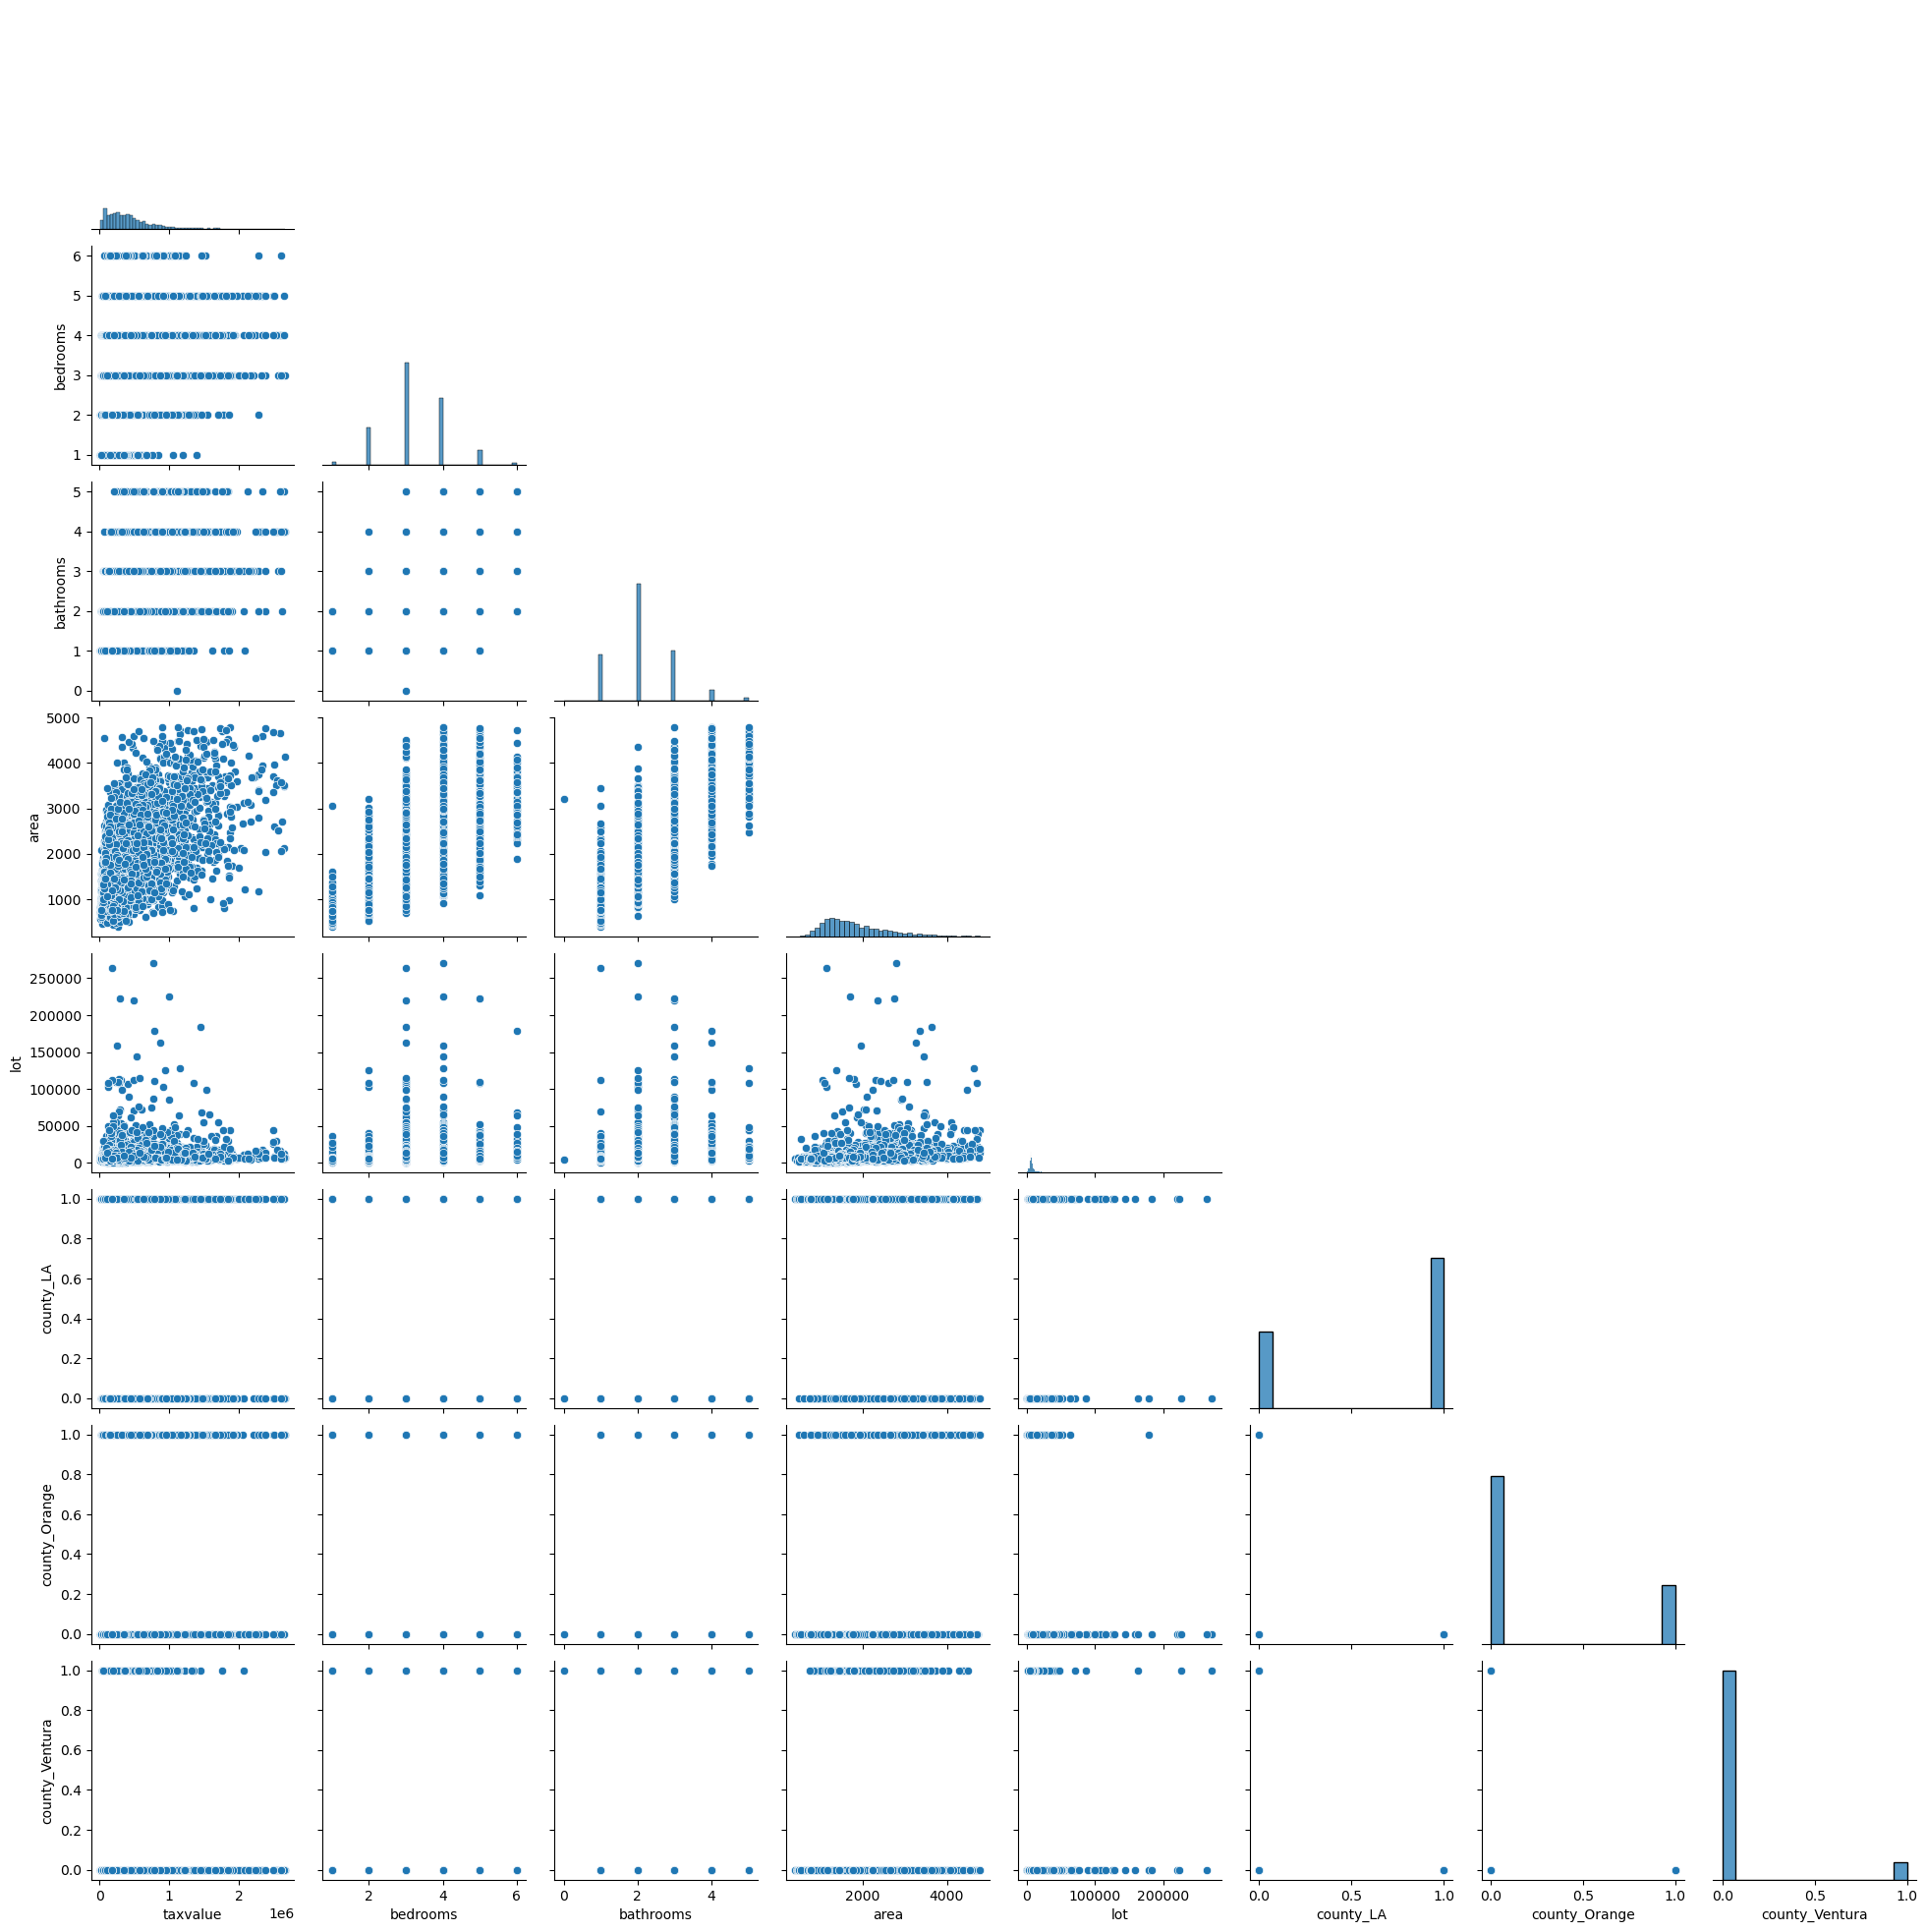

In [65]:
sns.pairplot(sample, corner=True)


aa

In [66]:
df=acquire.get_zillow_data()
df=prepare.prep_zillow(df)
train, validate, test = prepare.split_data(df)

csv file found and loaded

train -> (30273, 9), 60.0%
validate -> (10091, 9),20.0%
test -> (10092, 9), 20.0%


In [67]:
test.head()

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
33774,LA,2400051,3,2,1903,7000,1,0,0
45405,Orange,1054100,1,1,1600,6804,0,1,0
27802,Orange,325813,2,2,1819,14100,0,1,0
22944,Orange,725975,5,2,2246,9984,0,1,0
52114,LA,1264404,3,2,2150,6800,1,0,0


In [68]:
def plot_regression(train):
    sns.color_palette("magma")
    sns.lmplot(x="area", y="taxvalue", hue='county', data=train, scatter=True,scatter_kws={'alpha': 0.2}, line_kws={'linewidth': 3})
    plt.xlabel("Area in Sq.ft")
    plt.ylabel("Tax Value in USD millions")
    plt.title("Regression Plot: Area vs. Tax Value")
    plt.show()

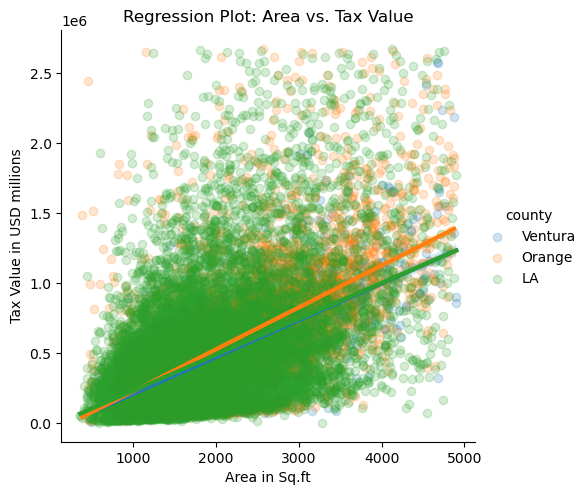

In [69]:
plot_regression(train)

In [70]:
f, p = stats.f_oneway(test.county_LA, test.county_Orange, test.county_Ventura)
f, p


(4766.941420369159, 0.0)

In [71]:
train.columns

Index(['county', 'taxvalue', 'bedrooms', 'bathrooms', 'area', 'lot',
       'county_LA', 'county_Orange', 'county_Ventura'],
      dtype='object')

## stats

In [73]:
'''
import pandas as pd
import scipy.stats as stats

def run_t_tests(test, y_var, x_vars):
    results = []
    
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(df[df[x_var] == 0][y_var], df[df[x_var] == 1][y_var])
        results.append({'x_variable': x_var, 'p_value': p_value})
    
    results_df = pd.DataFrame(results)
    return results_df

# Specify the x and y variables
x_vars = [ 'bedrooms', 'bathrooms', 'county_LA', 'county_Ventura', 'county_Orange']
y_var = 'taxvalue'

# Run t-tests
t_test_results = run_t_tests(test, y_var, x_vars)

# Display the results DataFrame
print(t_test_results)
results_df = pd.DataFrame({'Model': 'Logistic Regression','Accuracy': [accuracy], 'Recall': [recall]})
    return results_df

SyntaxError: EOF while scanning triple-quoted string literal (3811232738.py, line 26)

In [74]:
import pandas as pd
import scipy.stats as stats

def run_t_tests(test, y_var, x_vars):
    results = []
    
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(test[test[x_var] == 0][y_var], test[test[x_var] == 1][y_var])
        results.append({'x_variable': x_var, 'p_value': p_value})
    
    results_df = pd.DataFrame(results)
    return results_df
 

In [75]:
run_t_tests(test, y_var, x_vars)

NameError: name 'y_var' is not defined

In [76]:

def run_t_tests(test, y_var, x_vars):
    results = []
    a=0.05
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(test[test[x_var] == 0][y_var], test[test[x_var] == 1][y_var])
        
        # Round p-value to 4 decimal places
        rounded_p_value = round(p_value, 4)
        
        # Evaluate p-value compared to alpha
        if rounded_p_value < a:
            evaluation = "Reject Null"
        else:
            evaluation = "Fail to Reject"
            
        results.append({'x_variable': x_var, 'p_value': rounded_p_value, 'evaluation': evaluation})
    
    results_df = pd.DataFrame(results)
    return results_df



In [77]:
run_t_tests(test, y_var, x_vars)

NameError: name 'y_var' is not defined

##### Hypothisis for bedrooms
$H_0$ : The number bedrooms does not have a linear relationship to tax value<br>
$H_a$ : The number bedrooms does  have a linear relationship to tax value

In [78]:
def get_bstats(data):
    x_var = 'bedrooms'
    y_var = 'taxvalue'
    alpha=0.05
    # Perform Pearson correlation test
    r, p_value = stats.pearsonr(data[x_var], data[y_var])
    # Round p-value to 4 decimal places
    rounded_p_value = round(p_value, 6)
    # Evaluate p-value compared to alpha
    if rounded_p_value < alpha:
        evaluation = "Reject Null"
    else:
        evaluation = "Fail to Reject"
    results = {'x_variable': x_var, 'r': r, 'p_value': rounded_p_value, 'evaluation': evaluation}
    results_df = pd.DataFrame(results, index=[0])
    return results_df

In [79]:
get_brstats(test)

NameError: name 'get_brstats' is not defined

In [80]:
def run_bathttest(data):
    x = data['bathrooms']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [81]:
# Call the function with the 'train' DataFrame
run_bathttest(train)


,T-Statistic,P-Value,Decision
0,-205.166626,0.0,Reject Null Hypothesis


In [82]:
def run_lattest(data):
    x = data['county_LA']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [83]:
run_lattest(train)

,T-Statistic,P-Value,Decision
0,-205.16731,0.0,Reject Null Hypothesis


In [84]:
def run_ventttest(data):
    x = data['county_Ventura']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [85]:
run_ventttest(train)

,T-Statistic,P-Value,Decision
0,-205.167564,0.0,Reject Null Hypothesis


In [86]:
def run_bathttest(data):
    x = data['bathrooms']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [87]:
run_bathttest(train)

,T-Statistic,P-Value,Decision
0,-205.166626,0.0,Reject Null Hypothesis


In [88]:
def run_orangettest(data):
    x = data['county_Orange']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [89]:
run_orangettest(train)

,T-Statistic,P-Value,Decision
0,-205.167482,0.0,Reject Null Hypothesis


In [90]:
train.columns

Index(['county', 'taxvalue', 'bedrooms', 'bathrooms', 'area', 'lot',
       'county_LA', 'county_Orange', 'county_Ventura'],
      dtype='object')

In [91]:
import pandas as pd
from scipy import stats

def run_all_ttests(data):
    results = pd.DataFrame()  # Create an empty DataFrame to store the results
    
    # Run the T-tests for LA, Orange, and Ventura counties
    la_results = run_lattest(data)
    orange_results = run_orangettest(data)
    ventura_results = run_ventttest(data)
    
    # Concatenate the results into a single DataFrame
    results = pd.concat([results, la_results, orange_results, ventura_results], ignore_index=True)
    
    return results

# Call the function with the 'train' DataFrame
results_df = run_all_ttests(train)
print(results_df)


   T-Statistic  P-Value                Decision
0  -205.167310      0.0  Reject Null Hypothesis
1  -205.167482      0.0  Reject Null Hypothesis
2  -205.167564      0.0  Reject Null Hypothesis


In [92]:
run_all_ttests(train)

,T-Statistic,P-Value,Decision
0,-205.167310,0.0,Reject Null Hypothesis
1,-205.167482,0.0,Reject Null Hypothesis
2,-205.167564,0.0,Reject Null Hypothesis


In [93]:
import pandas as pd
from scipy import stats

def run_all_ttests(data):
    results = pd.DataFrame()  # Create an empty DataFrame to store the results
    
    # Run the T-tests for LA, Orange, and Ventura counties
    la_results = run_lattest(data)
    la_results['County'] = 'LA County'  # Add county name column
    orange_results = run_orangettest(data)
    orange_results['County'] = 'Orange County'  # Add county name column
    ventura_results = run_ventttest(data)
    ventura_results['County'] = 'Ventura County'  # Add county name column
    
    # Concatenate the results into a single DataFrame
    results = pd.concat([results, la_results, orange_results, ventura_results], ignore_index=True)
    
    return results

# Call the function with the 'train' DataFrame
results_df = run_all_ttests(train)
print(results_df)


   T-Statistic  P-Value                Decision          County
0  -205.167310      0.0  Reject Null Hypothesis       LA County
1  -205.167482      0.0  Reject Null Hypothesis   Orange County
2  -205.167564      0.0  Reject Null Hypothesis  Ventura County


In [94]:
run_all_ttests(train)

,T-Statistic,P-Value,Decision,County
0,-205.167310,0.0,Reject Null Hypothesis,LA County
1,-205.167482,0.0,Reject Null Hypothesis,Orange County
2,-205.167564,0.0,Reject Null Hypothesis,Ventura County


In [95]:

def get_areastats(data):
    '''
    This function reurns ther results from a pearsons r correlation test on area and tax value
    '''
    x_var='area'
    y_var='taxvalue'
    alpha=0.05
    # Perform Pearson correlation test
    r, p_value = stats.pearsonr(data[x_var], data[y_var])
    # Round p-value to 4 decimal places
    rounded_p_value = round(p_value, 4)

    # Evaluate p-value compared to alpha
    if rounded_p_value < alpha:
        evaluation = "Reject Null"
    else:
        evaluation = "Fail to Reject"
    results = {'x_variable': x_var, 'r': r, 'p_value': rounded_p_value, 'evaluation': evaluation}
    results_df = pd.DataFrame(results, index=[0])
    return results_df

In [96]:
get_areastats(train)

,x_variable,r,p_value,evaluation
0,area,0.549888,0.0,Reject Null


In [97]:
def bed_chart(data):
    # Specify the x and y variables
    x = data['bedrooms']
    y = data['taxvalue']
    # Create the scatter plot
    plt.scatter(x, y, alpha=0.5)
    # Set the labels and title
    plt.xlabel("Number of Bedrooms")
    plt.ylabel("Tax Value")
    plt.title("Number of Bedrooms vs. Tax Value")
    # Display the chart
    plt.show()

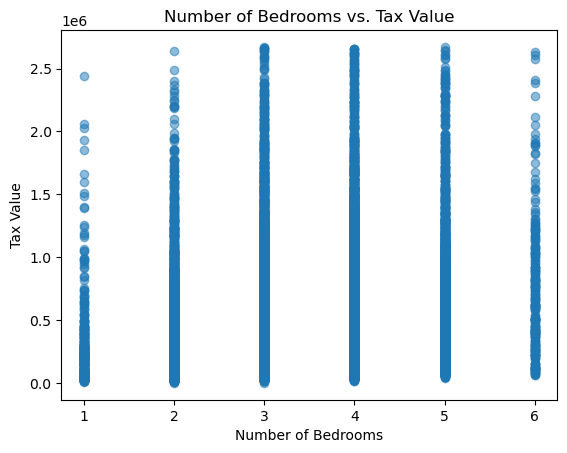

In [98]:
bed_chart(train)

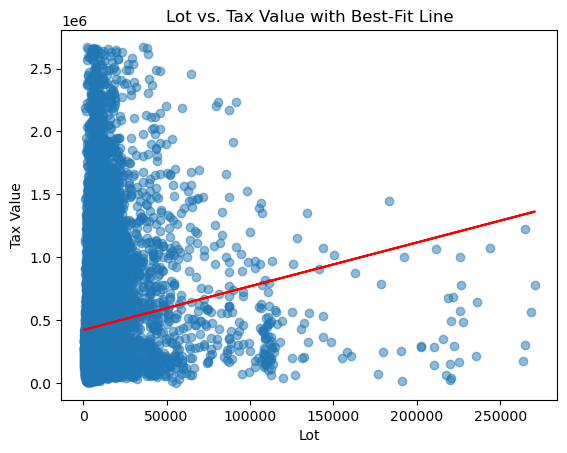

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Specify the x and y variables
x = train['lot']
y = train['taxvalue']

# Create the scatter plot
plt.scatter(x, y, alpha=0.5)

# Calculate the best-fit line
slope, intercept = np.polyfit(x, y, 1)
best_fit_line = slope * x + intercept

# Plot the best-fit line
plt.plot(x, best_fit_line, color='red')

# Set the labels and title
plt.xlabel("Lot")
plt.ylabel("Tax Value")
plt.title("Lot vs. Tax Value with Best-Fit Line")

# Display the chart
plt.show()


In [100]:
train.sample(2)

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
8065,Orange,1219039,4,4,2923,3615,0,1,0
28080,LA,130785,2,1,1259,4800,1,0,0


## modeling

In [101]:
def get_xy():
    '''
    This function generates X and y for train, validate, and test
    '''
    # create X & y version of train, where y is a series with just the target variable and X are all the features.    
    X_train = train.drop(['county'], axis=1)
    y_train = train.taxvalue
    X_validate = validate.drop(['county'], axis=1)
    y_validate = validate.taxvalue
    X_test = test.drop(['county'], axis=1)
    y_test = test.taxvalue
    return X_train,y_train,X_validate,y_validate,X_test,y_test
X_train, y_train, X_validate, y_validate, X_test, y_test = get_xy()

In [102]:
X_train, y_train, X_validate, y_validate, X_test, y_test = get_xy()

In [103]:
X_train

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
26821,403700,5,2,2510,8120,0,0,1
21357,862962,3,2,1353,5940,0,1,0
15544,734067,3,2,1687,6002,1,0,0
22074,278712,4,2,1455,6600,0,1,0
23745,289180,3,1,1082,5115,1,0,0
...,...,...,...,...,...,...,...,...
273,837386,4,2,1714,6505,1,0,0
14191,201229,3,2,1329,9651,1,0,0
28721,539346,4,2,2616,8798,0,1,0
17740,261903,3,1,988,5105,1,0,0


In [104]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data for the selected columns
scaler.fit(X_train[['area', 'lot']])

# Apply scaling to the selected columns in all data splits
X_train_scaled = X_train.copy()
X_train_scaled[['area', 'lot']] = scaler.transform(X_train[['area', 'lot']])

X_validate_scaled = X_validate.copy()
X_validate_scaled[['area', 'lot']] = scaler.transform(X_validate[['area', 'lot']])

X_test_scaled = X_test.copy()
X_test_scaled[['area', 'lot']] = scaler.transform(X_test[['area', 'lot']])


In [105]:
def scaling(train, validate, test):
    '''
    this function uses minmaxsccaler to scale the 'area' and 'lot' columns ofx train,validate and test
    '''
    # Create a scaler object
    scaler = MinMaxScaler()
    # Fit the scaler on the training data for the selected columns
    scaler.fit(X_train[['area', 'lot']])
    # Apply scaling to the selected columns in all data splits
    X_train_scaled = X_train.copy()
    X_train_scaled[['area', 'lot']] = scaler.transform(X_train[['area', 'lot']])
    X_validate_scaled = X_validate.copy()
    X_validate_scaled[['area', 'lot']] = scaler.transform(X_validate[['area', 'lot']])
    X_test_scaled = X_test.copy()
    X_test_scaled[['area', 'lot']] = scaler.transform(X_test[['area', 'lot']])
    return X_train_scaled,X_validate_scaled,X_test_scaled

In [106]:
scaling(train, validate, test)

(       taxvalue  bedrooms  bathrooms      area       lot  county_LA  \
 26821    403700         5          2  0.473360  0.028273          0   
 21357    862962         3          2  0.218626  0.020206          0   
 15544    734067         3          2  0.292162  0.020435          1   
 22074    278712         4          2  0.241083  0.022648          0   
 23745    289180         3          1  0.158961  0.017153          1   
 ...         ...       ...        ...       ...       ...        ...   
 273      837386         4          2  0.298107  0.022296          1   
 14191    201229         3          2  0.213342  0.033939          1   
 28721    539346         4          2  0.496697  0.030782          0   
 17740    261903         3          1  0.138265  0.017116          1   
 29833    240586         3          2  0.300749  0.030538          1   
 
        county_Orange  county_Ventura  
 26821              0               1  
 21357              1               0  
 15544        

In [107]:
X_train_scaled

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
26821,403700,5,2,0.473360,0.028273,0,0,1
21357,862962,3,2,0.218626,0.020206,0,1,0
15544,734067,3,2,0.292162,0.020435,1,0,0
22074,278712,4,2,0.241083,0.022648,0,1,0
23745,289180,3,1,0.158961,0.017153,1,0,0
...,...,...,...,...,...,...,...,...
273,837386,4,2,0.298107,0.022296,1,0,0
14191,201229,3,2,0.213342,0.033939,1,0,0
28721,539346,4,2,0.496697,0.030782,0,1,0
17740,261903,3,1,0.138265,0.017116,1,0,0


In [108]:
from sklearn.preprocessing import MinMaxScaler

def scaling(train, validate, test):
    """
    Perform Min-Max scaling on selected columns of the train, validate, and test data.

    Args:
        train (pd.DataFrame): Training data.
        validate (pd.DataFrame): Validation data.
        test (pd.DataFrame): Test data.
        columns (list): List of column names to scale.
    Returns:
        pd.DataFrame: Scaled train, validate, and test data.
    """
    # Define the columns to scale
    columns = ['area', 'lot']
    # Create a scaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data for the selected columns
    scaler.fit(train[columns])

    # Apply scaling to the selected columns in all data splits
    train_scaled = train.copy()
    train_scaled[columns] = scaler.transform(train[columns])

    validate_scaled = validate.copy()
    validate_scaled[columns] = scaler.transform(validate[columns])

    test_scaled = test.copy()
    test_scaled[columns] = scaler.transform(test[columns])

    return train_scaled, validate_scaled, test_scaled


In [109]:


# Call the scaling function
X_train_scaled, X_validate_scaled, X_test_scaled = scaling(X_train, X_validate, X_test)


In [110]:
X_train_scaled

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
26821,403700,5,2,0.473360,0.028273,0,0,1
21357,862962,3,2,0.218626,0.020206,0,1,0
15544,734067,3,2,0.292162,0.020435,1,0,0
22074,278712,4,2,0.241083,0.022648,0,1,0
23745,289180,3,1,0.158961,0.017153,1,0,0
...,...,...,...,...,...,...,...,...
273,837386,4,2,0.298107,0.022296,1,0,0
14191,201229,3,2,0.213342,0.033939,1,0,0
28721,539346,4,2,0.496697,0.030782,0,1,0
17740,261903,3,1,0.138265,0.017116,1,0,0


In [111]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(train, validate, test):
    """
    Scale the selected columns in the train, validate, and test data.

    Args:
        train (pd.DataFrame): Training data.
        validate (pd.DataFrame): Validation data.
        test (pd.DataFrame): Test data.
        columns (list): List of column names to scale.

    Returns:
        tuple: Scaled data as (X_train_scaled, X_validate_scaled, X_test_scaled).
    """
    # Create X and y for train, validate, and test
    X_train = train.drop(['county'], axis=1)
    y_train = train['taxvalue']
    X_validate = validate.drop(['county'], axis=1)
    y_validate = validate['taxvalue']
    X_test = test.drop(['county'], axis=1)
    y_test = test['taxvalue']

    # Create a scaler object
    scaler = MinMaxScaler()
    columns =['area','lot']
    # Fit the scaler on the training data for the selected columns
    scaler.fit(X_train[columns])

    # Apply scaling to the selected columns in all data splits
    X_train_scaled = X_train.copy()
    X_train_scaled[columns] = scaler.transform(X_train[columns])

    X_validate_scaled = X_validate.copy()
    X_validate_scaled[columns] = scaler.transform(X_validate[columns])

    X_test_scaled = X_test.copy()
    X_test_scaled[columns] = scaler.transform(X_test[columns])

    return X_train_scaled, X_validate_scaled, X_test_scaled


In [112]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics_reg(y_true, y_pred):
    """
    Calculate RMSE and R2 scores.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        tuple: Tuple containing RMSE and R2 scores.
    """
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


def get_baseline(y_true):
    """
    Calculate RMSE and R2 scores for the baseline model.

    Args:
        y_true (array-like): True target values.

    Returns:
        pd.DataFrame: DataFrame with baseline model metrics.
    """
    baseline = y_true.mean()
    baseline_array = np.repeat(baseline, len(y_true))
    rmse, r2 = metrics_reg(y_true, baseline_array)

    metrics_df = pd.DataFrame(data=[{
        'model': 'baseline',
        'rmse': rmse,
        'r2': r2
    }])

    return metrics_df




In [113]:
baseline_metrics = get_baseline(y_train)


In [114]:
baseline_metrics


,model,rmse,r2
0,baseline,383891.952694,0.0


In [115]:
import explore
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train_scaled, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train_scaled)

#use it on validate
X_val_rfe = rfe.transform(X_validate_scaled)
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [116]:
print('selected top feature:', rfe.get_feature_names_out())


selected top feature: ['taxvalue']


## restart spot models

In [117]:
# Acquiring data
df = acquire.get_zillow_data()
# Running initial preperation for exploration
df = prepare.prep_zillow(df)
# Split
train, validate, test = prepare.split_data(df)

csv file found and loaded

train -> (30273, 9), 60.0%
validate -> (10091, 9),20.0%
test -> (10092, 9), 20.0%


In [118]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = explore.scale_data(train, validate, test, ['area', 'lot'])

In [119]:
explore.get_blinemetrics(y_train)

,model,rmse,r2
0,baseline,383891.952694,0.0


In [120]:
X_train_scaled.head()

,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
26821,5,2,0.473360,0.028273,0,0,1
21357,3,2,0.218626,0.020206,0,1,0
15544,3,2,0.292162,0.020435,1,0,0
22074,4,2,0.241083,0.022648,0,1,0
23745,3,1,0.158961,0.017153,1,0,0


In [121]:
y_test

33774    2400051
45405    1054100
27802     325813
22944     725975
52114    1264404
          ...   
5201      914399
51013    1192000
38123     410000
6083      354358
7449      238548
Name: taxvalue, Length: 10092, dtype: int64

In [ ]:
# simple linear regression + RFE

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


In [125]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train_scaled, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train_scaled)

#use it on validate
X_validate_rfe = rfe.transform(X_validate_scaled)

In [126]:
print('selected top feature:', rfe.get_feature_names_out())


selected top feature: ['county_LA']


In [128]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)
pred_lr1[:10]


array([522241.24796864, 522241.24796864, 414623.92277419, 522241.24796864,
       414623.92277419, 522241.24796864, 414623.92277419, 414623.92277419,
       414623.92277419, 522241.24796864])

In [129]:
#eval
#train
metrics_reg(y_train, pred_lr1)

(380428.1909468996, 0.01796409323759407)

In [130]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(64486464875.23845, -27476008905.35503)


### Multiple Regression -OLS

In [133]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train_scaled, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train_scaled)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate_scaled)
pred_lr2[:10]


array([490048., 366464., 417024., 312128., 194624., 296448., 281664.,
       628800., 847360., 761216.])

In [134]:
# eval

In [135]:
#train 
metrics_reg(y_train, pred_lr2)

(315053.35844584135, 0.326480443785765)

In [136]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(318603.09512171155, 0.3293182481586455)

In [137]:
lr1.intercept_


522241.24796864274

In [138]:
lr1.coef_


array([-107617.32519446])

In [139]:
print(f'taxvalue = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*')


taxvalue = 5.22e+05 + -1.1e+05*


### LassoLars

In [144]:
#import
from sklearn.linear_model import LassoLars

In [145]:
#make it
lars = LassoLars(alpha=0)

#fit it
lars.fit(X_train_scaled, y_train)

#use it
pred_lars = lars.predict(X_train_scaled)

In [146]:
pd.Series(lars.coef_, index=lars.feature_names_in_)


bedrooms         -8.405112e+04
bathrooms         4.756862e+04
area              1.317636e+06
lot              -2.073872e+05
county_LA        -1.497917e+03
county_Orange     4.459201e+04
county_Ventura    0.000000e+00
dtype: float64

In [147]:
lr2.coef_


array([-8.34102456e+04,  4.75675434e+04,  1.31756726e+06, -2.07097822e+05,
       -3.05965188e+17, -3.05965188e+17, -3.05965188e+17])

In [148]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train_scaled, y_train)

#use it
pred_lars = lars.predict(X_train_scaled)
pred_val_lars = lars.predict(X_validate_scaled)

In [ ]:
#### eval

In [149]:
#train
metrics_reg(y_train, pred_lars)

(315052.900207615, 0.32648240302329834)

In [150]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(318606.84286084253, 0.32930246956096243)

### Polynomial Regression

In [151]:
from sklearn.preprocessing import PolynomialFeatures


In [163]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [153]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [154]:
#eval

In [155]:
#train
metrics_reg(y_train, pred_pr)

(6.525712414071498e-05, 1.0)

In [156]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(6.87456844259328e-05, 1.0)

### Generalized Linear Model (GLM)

In [157]:
from sklearn.linear_model import TweedieRegressor

#make it
glm = TweedieRegressor(power=1, alpha=0)

#fit it
glm.fit(X_train_scaled, y_train)

#use it
pred_glm = glm.predict(X_train_scaled)
pred_val_glm = glm.predict(X_validate_scaled)

In [158]:
#### eval

In [159]:
#train
metrics_reg(y_train, pred_glm)


(315270.6999759804, 0.32555085989858756)

In [160]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(318242.26115022955, 0.33083654928353423)

In [161]:
### best of models

In [164]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([2400050.99943005, 1054100.00001274,  325813.00002997, ...,
        410000.00003179,  354358.00004067,  238548.00001946])

In [165]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(6.497001453153035e-05, 1.0)

In [173]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def run_regression_models(X_train, y_train, X_val, y_val):
    """
    Run multiple regression models and evaluate the results.

    Args:
        X_train (pd.DataFrame): Scaled features of the training set.
        y_train (pd.Series): Target variable of the training set.
        X_val (pd.DataFrame): Scaled features of the validation set.
        y_val (pd.Series): Target variable of the validation set.

    Returns:
        pd.DataFrame: DataFrame with evaluation results for each model.
    """
    models = {
        "Linear Regression (OLS)": LinearRegression(),
        "LassoLars": LassoLars(),
        "Tweedie Regressor (GLM)": TweedieRegressor(),
        "Polynomial Regression": PolynomialFeatures(degree=3)
    }

    results = []

    for model_name, model in models.items():
        # Fit the model
        if isinstance(model, PolynomialFeatures):
            X_train_transformed = model.fit_transform(X_train)
            X_val_transformed = model.transform(X_val)
            model = LinearRegression()  # Use Linear Regression on transformed features
            model.fit(X_train_transformed, y_train)
            y_train_pred = model.predict(X_train_transformed)
            y_val_pred = model.predict(X_val_transformed)
        else:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

        # Evaluate the model
        train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
        val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        # Store the results
        result = {
            "Model": model_name,
            "Train RMSE": train_rmse,
            "Validation RMSE": val_rmse,
            "Train R2": train_r2,
            "Validation R2": val_r2
        }
        results.append(result)

    return pd.DataFrame(results)



In [174]:
results_df = run_regression_models(X_train_scaled, y_train, X_validate_scaled, y_validate)
results_df


,Model,Train RMSE,Validation RMSE,Train R2,Validation R2
0,Linear Regression (OLS),315053.358446,318603.095122,0.326480,0.329318
1,LassoLars,315052.900208,318606.842861,0.326482,0.329302
2,Tweedie Regressor (GLM),353491.097199,357823.995402,0.152111,0.154029
3,Polynomial Regression,311270.137298,314149.872266,0.342559,0.347936


In [203]:
plt.bar(results_df.Model, results_df['Train RMSE'])

KeyError: 'Train RMSE'

In [180]:

def apply_polynomial_regression(model, X_test_scaled, y_test, degree):
    """
    Apply polynomial regression model to the scaled test data.

    Args:
        model: Trained polynomial regression model.
        X_test_scaled: Scaled test features.
        y_test: Test target variable.
        degree: Degree of the polynomial features.

    Returns:
        pd.DataFrame: DataFrame with predicted values and evaluation metrics.
    """
    # Transform test data into polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.fit_transform(X_test_scaled)

    # Predict the target variable using the polynomial features
    y_test_pred = model.predict(X_test_poly)

    # Calculate evaluation metrics
    rmse, r2 = metrics_reg(y_test, y_test_pred)

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Model': ['Polynomial Regression'],
        'RMSE': [rmse],
        'R2': [r2]
    })

    return results_df



In [181]:
apply_polynomial_regression(model, X_test_scaled, y_test, 3)

NameError: name 'model' is not defined

In [192]:
def apply_polynomial_regression(X_test_scaled, y_test, degree=3):
    """
    to run:
    results_df = apply_polynomial_regression(X_test_scaled, y_test, degree=3)
    results_df
    Apply polynomial regression on the scaled test data.
    Args:
        X_test_scaled: Scaled test features.
        y_test: Test target values.
        degree: Degree of the polynomial features.
    Returns:
        pd.DataFrame: DataFrame with the test results.
    """
    # Transform test data into polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.fit_transform(X_test_scaled)
    # Fit polynomial regression on the training data
    model = LinearRegression()
    model.fit(X_test_poly, y_test)
    # Make predictions on the test data
    y_pred = model.predict(X_test_poly)
    # Evaluate the model performance
    rmse, r2 = metrics_reg(y_test, y_pred)
    # Create a DataFrame with the test results
    results_df = pd.DataFrame({
        'Model': ['Polynomial Regression'],
        'RMSE': [rmse],
        'R2': [r2]
    })

    return results_df


In [193]:
results_df = apply_polynomial_regression(X_test_scaled, y_test, degree=3)
results_df

,Model,RMSE,R2
0,Polynomial Regression,307698.389898,0.370751


NameError: name 'baseline' is not defined

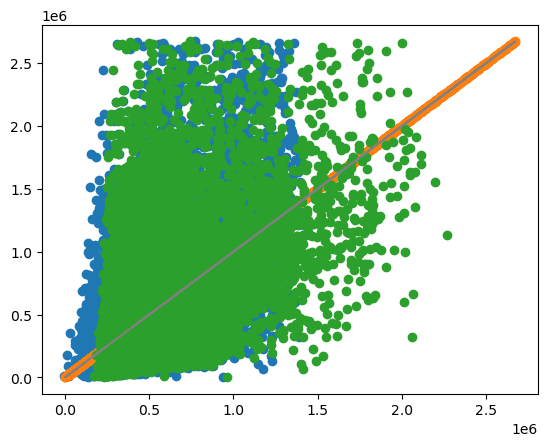

In [194]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual Final Grade")
plt.xlabel("Predicted Final Grade")
plt.legend()

plt.show()

In [204]:
import matplotlib.pyplot as plt




KeyError: 'Validation RMSE'

In [218]:
def get_distplot():
    # Plot the distribution of the target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(train['taxvalue'], kde=True)
    plt.xlabel('Tax Value in millions USD')
    plt.ylabel('Count')
    plt.title('Distribution of Tax Values')
    # Add a vertical line for the baseline RMSE
    plt.axvline(x=383891.952694, color='red', linestyle='--', label='Baseline RMSE')
    plt.legend()
    plt.show()

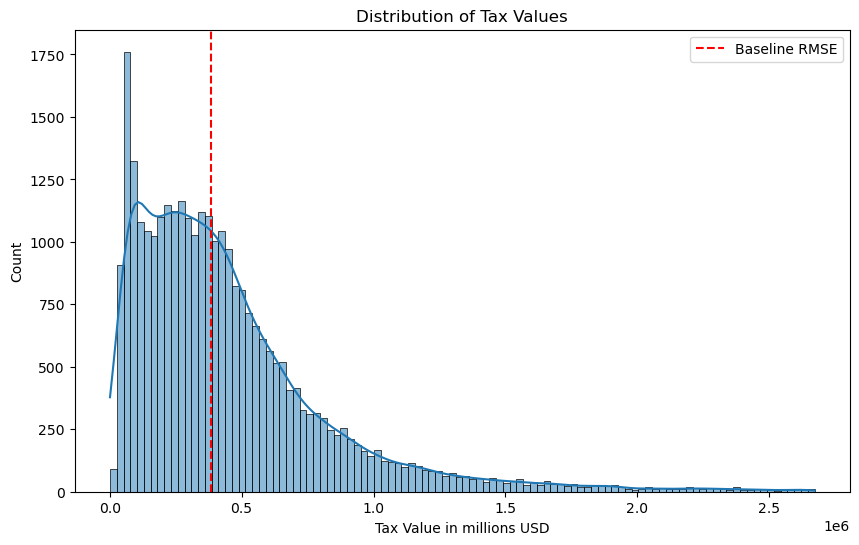

In [219]:
get_distplot()